# TODO: clean up this file; make final fig...

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_mouse_diet_perturbations_dataset
from mcspace.utils import get_device, pickle_load, pickle_save,\
    estimate_process_variance, MODEL_FILE, DATA_FILE, \
    get_mcspace_cooccur_prob, get_sig_perturbation_diff_subset, \
    get_posterior_summary_data, get_pert_otu_sub, get_min_loss_path, apply_taxonomy_threshold, \
    get_summary_results
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import mcspace.visualization as vis
from mcspace.dataset import DataSet
import pandas as pd

import ete3
from Bio import SeqIO, Phylo

import mcspace.vis_tools as vis
# from mcspace.fig_utils import *''
import matplotlib.colors as mcolors

In [2]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

# Paths

In [3]:
pwd

'C:\\Users\\Gary\\Partners HealthCare Dropbox\\Gurdip Uppal\\research_bwh\\MCSPACE_FINAL\\MCSPACE\\mcspace\\paper\\figures'

In [4]:
rootpath = Path("../../")
basepath = Path("./")

In [5]:
runpath = rootpath / "paper" / "human_runs" / "runs"

In [6]:
treepath = rootpath / "data" / "human_experiments" / "human_otus_tree" / "output" # *** rename this
treefile = "newick_tree_query_reads.nhx"

In [7]:
outpath = basepath / "figs_human_results"
outpath.mkdir(exist_ok=True, parents=True)

# Load best model results

In [8]:
respath = get_min_loss_path(runpath, np.arange(10))

c:\users\gary\partners healthcare dropbox\gurdip uppal\research_bwh\mcspace_final\mcspace\mcspace\utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.l

0
1
2
3
4
5
6
7
8
9
3


In [9]:
model = torch.load(respath / MODEL_FILE)
data = pickle_load(respath / DATA_FILE)

taxonomy_temp = pickle_load(respath / "taxonomy.pkl")

times = list(data['count_data'].keys())
subjects = list(data['count_data'][1].keys())
num_otus = data['count_data'][times[0]][subjects[0]].shape[1]
num_times = len(times)
num_subjects = len(subjects)

C:\Users\Gary\AppData\Local\Temp\ipykernel_66032\2930395400.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(respath / MODEL_FILE)


In [10]:
print(times)
print(subjects)
print(num_otus)

[1, 2, 3, 4, 5]
['H11']
58


In [11]:
taxonomy_temp.head()

,Kingdom,Phylum,Class,Order,Family,Genus
Otu,,,,,,
Otu121,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,na
Otu14,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,na
Otu150,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,uncultured
Otu37,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides
Otu6,Bacteria,Actinobacteriota,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium


### load final taxonomy

In [12]:
taxfile =  rootpath / "data" / "human_experiments" / "gappa_taxonomy" / "human_taxonomy.csv"
finaltax = pd.read_csv(taxfile, index_col=0)

In [13]:
finaltax.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu1720,Bacteria,Firmicutes,Clostridia,Clostridiales,Oscillospiraceae,Oscillibacter,Oscillibacter valericigenes
Otu3529,Bacteria,Proteobacteria,Gammaproteobacteria,Thiotrichales,Thiotrichaceae,Thiothrix,na
Otu3620,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,na
Otu93,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,na
Otu3524,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans


In [14]:
taxlist = list(taxonomy_temp.index)
taxonomy = finaltax.loc[taxlist,:]

In [15]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Otu,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na


# Get summary results

In [16]:
thetadf, betadf, pertsdf = get_posterior_summary_data(model, data, taxonomy, times, subjects)

In [17]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005086,-2.293650
1,1,H11,A2,0.007052,-2.151709
2,1,H11,A3,0.027520,-1.560352
3,1,H11,A4,0.012623,-1.898830
4,1,H11,A5,0.059641,-1.224453
...,...,...,...,...,...
340,5,H11,A65,0.007100,-2.148770
341,5,H11,A66,0.005401,-2.267514
342,5,H11,A67,0.009518,-2.021453
343,5,H11,A68,0.001261,-2.899237


# Render figure

### methods (move to utils)

In [18]:
def get_abundance_order(betadf):
    betadf_drop = betadf[['Assemblage', 'Value']]
    aveval = betadf_drop.groupby('Assemblage').mean()
    beta_order = aveval.sort_values(by='Value', ascending=False).index
    return beta_order

In [19]:
# vs plot_proportions_timepoint_subjects...?
def plot_subject_proportions_timeseries(ax, betadf, subj, order, logscale=True, vmin=-2, vmax=0, cmap='Blues',
                                   linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=True,
                                   square=False, cbar=False):
    if logscale is True:
        val = 'log10Value'
    else:
        val = 'Value'
        
    betasub = betadf.loc[(betadf['Subject'] == subj),:]
    betamatrix = betasub.pivot(index='Time', columns='Assemblage', values=val)
    ax=sns.heatmap(betamatrix.loc[:,order], ax=ax, cmap=cmap, square=square, vmin=vmin, vmax=vmax, cbar=cbar,
               linewidth=linewidth, linecolor=linecolor, xticklabels=xticklabels, yticklabels=yticklabels)
    return ax

In [20]:
def get_lowest_level(otu, taxonomy):
    taxonomies = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Domain']
    for level in taxonomies:
        levelid = taxonomy.loc[otu,level]
        if levelid != 'na':
            return levelid, level

In [21]:
def plot_phylo_tree(ax, tree, taxonomy, fontsize=16, text_len=41):            
    TEXT_LEN=text_len
    prefix_taxa = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****',
                   'Class': '*****', 'Phylum': '******', 'Domain': '*******'}

    Phylo.draw(tree, axes=ax, do_show=False, show_confidence=False)
    taxa_order = []

    for text in ax.texts:
        taxonname = str(text._text).replace(' ','').capitalize()
        otu_name = taxonname
        taxa_order.append(otu_name)
        name, level = get_lowest_level(otu_name, taxonomy)
        prefix = prefix_taxa[level]
        taxonname = ' ' + prefix + ' ' + name + ' ' + otu_name
        text._text = taxonname
        text._text = text._text + '- ' * (TEXT_LEN - len(text._text))
        text.set_fontsize(fontsize)
    
    ax = remove_border(ax)
    return ax, taxa_order

In [22]:
def plot_assemblages(ax, thetadf, otu_order, beta_order, cmap=None, logscale=True, vmin=-2, vmax=0,
               linecolor ='#e6e6e6', linewidth=0.5, xticklabels=True, yticklabels=False,
               square=False, cbar=False):
    
    # reset multiindex
    thetatemp = thetadf.reset_index()
    thetatemp=thetatemp.set_index('Otu')
    
    if logscale is True:
        thetaplot = np.log10(thetatemp.loc[otu_order,:][beta_order] + 1e-20)
    else:
        thetaplot = thetatemp.loc[otu_order,:][beta_order]
    
    if cmap is None:
        green = sns.light_palette("green", reverse=False, as_cmap=True)
        green.set_under('white')
        cmap=green
    cbar_kws = dict(extend='min')

    ax=sns.heatmap(thetaplot, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, linecolor=linecolor, linewidth=linewidth,
               xticklabels=xticklabels, yticklabels=yticklabels, square=square, cbar=cbar, cbar_kws=cbar_kws)
    return ax

In [23]:
def remove_border(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax

In [24]:
def add_border(ax, color='black'):
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color(color)
    return ax

In [25]:
# TODO : fix tree names so standardized?...
def get_pruned_tree(treepath, treefile, taxonomy, temppath=Path("./_tmp")):
    tree = ete3.Tree((treepath / treefile).as_posix())
    print("original tree size:", len(tree))
    taxaids = list(taxonomy.index)
    taxaids = [idx.upper() for idx in taxaids] # HOW TO KNOW IF NEEDED?...
    tree.prune(taxaids, True)
    print("pruned tree size:", len(tree))
    
    treeout = "tree.nhx"
    temppath.mkdir(exist_ok=True, parents=True)
    tree.write(outfile=(temppath / treeout).as_posix())
    phylo_tree = Phylo.read(temppath / treeout, format='newick')
    return phylo_tree

## settings

In [26]:
taxonomy.rename(columns={"Kingdom":"Domain"}, inplace=True)

In [27]:
fontsize = 12
subfontsize = 8

In [28]:
nsubj = len(subjects)
ntime = len(times)
notus, ncomm = thetadf.shape

## plot

In [29]:
ncomm_max = 120
notu_max = 120

tree_ratio = 0.1
gap_ratio = 0.15

original tree size: 3923
pruned tree size: 58


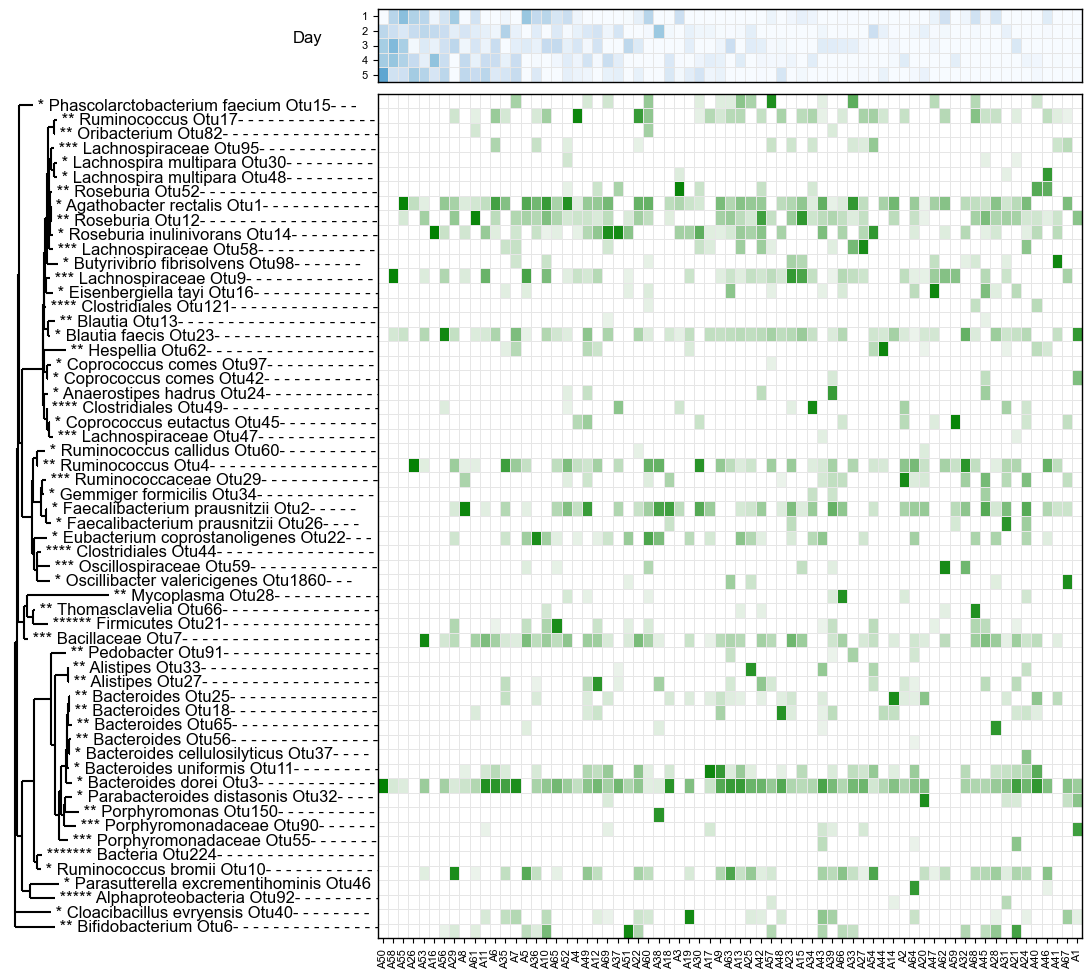

In [30]:
scale=2

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max]
hratios.append(notus/notu_max)
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max)) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=1+2,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_tree = fig.add_subplot(gs[1,0])
ax_theta = fig.add_subplot(gs[1,2])

# plot assemlage proportions
beta_order = get_abundance_order(betadf)

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=50, ha='left', fontsize=fontsize)
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize)

# plot assemblages
ax_theta=plot_assemblages(ax_theta, thetadf, otu_order, beta_order) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)

## add variance over time

In [31]:
# thetadf

In [32]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005086,-2.293650
1,1,H11,A2,0.007052,-2.151709
2,1,H11,A3,0.027520,-1.560352
3,1,H11,A4,0.012623,-1.898830
4,1,H11,A5,0.059641,-1.224453
...,...,...,...,...,...
340,5,H11,A65,0.007100,-2.148770
341,5,H11,A66,0.005401,-2.267514
342,5,H11,A67,0.009518,-2.021453
343,5,H11,A68,0.001261,-2.899237


In [33]:
def get_subj_averaged_assemblage_proportions(betadf):
    subjave = betadf.loc[:,['Time','Assemblage','Value']].groupby(by=['Time','Assemblage']).mean()
    subjave.reset_index(inplace=True)
    betamat = subjave.pivot(index='Time', columns='Assemblage', values='Value')
    return betamat

In [34]:
avebeta = get_subj_averaged_assemblage_proportions(betadf)

In [35]:
betadf

,Time,Subject,Assemblage,Value,log10Value
0,1,H11,A1,0.005086,-2.293650
1,1,H11,A2,0.007052,-2.151709
2,1,H11,A3,0.027520,-1.560352
3,1,H11,A4,0.012623,-1.898830
4,1,H11,A5,0.059641,-1.224453
...,...,...,...,...,...
340,5,H11,A65,0.007100,-2.148770
341,5,H11,A66,0.005401,-2.267514
342,5,H11,A67,0.009518,-2.021453
343,5,H11,A68,0.001261,-2.899237


In [36]:
avebeta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005086,0.038501,0.005905,0.006020,0.006212,0.004502,0.014791,0.012369,0.008850,0.002939,...,0.003945,0.003480,0.021644,0.010315,0.002712,0.024854,0.004959,0.007007,0.010345,0.004143
2,0.004595,0.008073,0.014956,0.023427,0.010794,0.010251,0.008108,0.033123,0.011994,0.011174,...,0.010312,0.011711,0.018802,0.010303,0.006973,0.010757,0.012357,0.014197,0.021857,0.010505
3,0.002197,0.031837,0.013180,0.023536,0.008093,0.011498,0.008670,0.014300,0.006894,0.007393,...,0.028139,0.008005,0.032251,0.015696,0.002817,0.003478,0.007386,0.015733,0.012068,0.012410
4,0.002435,0.008395,0.029107,0.010989,0.017411,0.010879,0.006916,0.065324,0.015942,0.019776,...,0.006654,0.009606,0.011880,0.006081,0.007700,0.000903,0.028452,0.029017,0.032866,0.014532
5,0.000886,0.005407,0.037243,0.006357,0.010025,0.008308,0.011263,0.021726,0.012271,0.019815,...,0.005702,0.011010,0.007100,0.005401,0.009518,0.001261,0.014518,0.030867,0.034671,0.013951


### add stats

In [37]:
beta = avebeta.T
beta['Min'] = beta.min(axis=1)
beta['Max'] = beta.max(axis=1)
beta['Mean'] = beta.mean(axis=1)
beta['Variance of log'] = np.log(beta).var(axis=1)
beta = beta.T

In [38]:
beta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005086,0.038501,0.005905,0.006020,0.006212,0.004502,0.014791,0.012369,0.008850,0.002939,...,0.003945,0.003480,0.021644,0.010315,0.002712,0.024854,0.004959,0.007007,0.010345,0.004143
2,0.004595,0.008073,0.014956,0.023427,0.010794,0.010251,0.008108,0.033123,0.011994,0.011174,...,0.010312,0.011711,0.018802,0.010303,0.006973,0.010757,0.012357,0.014197,0.021857,0.010505
3,0.002197,0.031837,0.013180,0.023536,0.008093,0.011498,0.008670,0.014300,0.006894,0.007393,...,0.028139,0.008005,0.032251,0.015696,0.002817,0.003478,0.007386,0.015733,0.012068,0.012410
4,0.002435,0.008395,0.029107,0.010989,0.017411,0.010879,0.006916,0.065324,0.015942,0.019776,...,0.006654,0.009606,0.011880,0.006081,0.007700,0.000903,0.028452,0.029017,0.032866,0.014532
5,0.000886,0.005407,0.037243,0.006357,0.010025,0.008308,0.011263,0.021726,0.012271,0.019815,...,0.005702,0.011010,0.007100,0.005401,0.009518,0.001261,0.014518,0.030867,0.034671,0.013951
Min,0.000886,0.005407,0.005905,0.006020,0.006212,0.004502,0.006916,0.012369,0.006894,0.002939,...,0.003945,0.003480,0.007100,0.005401,0.002712,0.000903,0.004959,0.007007,0.010345,0.004143
Max,0.005086,0.038501,0.037243,0.023536,0.017411,0.011498,0.014791,0.065324,0.015942,0.019815,...,0.028139,0.011711,0.032251,0.015696,0.009518,0.024854,0.028452,0.030867,0.034671,0.014532
Mean,0.003025,0.019446,0.020506,0.014269,0.010880,0.008777,0.010208,0.032076,0.011255,0.011979,...,0.012405,0.008429,0.018718,0.009842,0.005993,0.009573,0.014440,0.019242,0.022403,0.010602
Variance of log,0.511956,0.742682,0.552387,0.392477,0.160674,0.154479,0.093420,0.470515,0.110688,0.644923,...,0.623852,0.257076,0.361783,0.191184,0.316174,2.000530,0.479688,0.374025,0.285286,0.282812


In [39]:
beta = beta.loc[:,thetadf.columns]

In [40]:
thetadf

,,,,,,,,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Otu,Kingdom,Phylum,Class,Order,Family,Genus,Species,,,,,,,,,,,,,,,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000052,0.000014,0.000242,0.000437,1.781666e-06,0.001734,0.003279,0.000093,0.000574,0.004239,...,0.011149,0.000042,0.000004,7.585302e-05,0.002550,0.002987,0.001211,0.000604,0.021730,0.003368
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans,0.005940,0.000244,0.041221,0.010959,5.553787e-06,0.012431,0.016941,0.016841,0.011932,0.010213,...,0.003474,0.002708,0.012941,1.539850e-02,0.013372,0.011733,0.034129,0.002216,0.008005,0.543192
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na,0.000012,0.000029,0.000016,0.000053,1.714669e-07,0.000009,0.000002,0.000103,0.000013,0.000035,...,0.000024,0.000037,0.000036,3.372271e-07,0.000025,0.001509,0.000070,0.000007,0.001506,0.000035
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,0.000149,0.000675,0.000004,0.000026,5.252889e-07,0.001403,0.003581,0.001785,0.009265,0.000269,...,0.000852,0.000032,0.004395,1.780347e-03,0.000019,0.000015,0.000966,0.000068,0.000111,0.000026
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na,0.002488,0.002598,0.000010,0.003122,2.498775e-02,0.001897,0.001975,0.000546,0.000764,0.094230,...,0.000474,0.012422,0.004437,9.384204e-04,0.001704,0.006746,0.026253,0.003690,0.000035,0.000870
Otu44,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000038,0.000017,0.001171,0.000354,2.908277e-03,0.000014,0.000006,0.000458,0.000013,0.000019,...,0.001546,0.000320,0.000019,2.206491e-07,0.001327,0.000003,0.001769,0.004341,0.001252,0.000031
Otu97,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Coprococcus,Coprococcus comes,0.002998,0.004874,0.000416,0.000021,6.522418e-07,0.002026,0.001114,0.000435,0.000667,0.000321,...,0.000163,0.000077,0.000001,5.793259e-04,0.002030,0.003152,0.003495,0.004502,0.000007,0.003781
Otu1,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Agathobacter rectalis,0.000646,0.002941,0.032693,0.011973,1.912717e-01,0.261411,0.005512,0.013557,0.090957,0.329543,...,0.134887,0.016446,0.070716,3.075098e-02,0.049347,0.036132,0.013606,0.087025,0.022871,0.100495
Otu34,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Gemmiger,Gemmiger formicilis,0.000039,0.002609,0.000019,0.001345,5.264282e-03,0.001380,0.000005,0.000626,0.000043,0.000072,...,0.001620,0.000129,0.000006,2.034993e-06,0.000007,0.004735,0.004186,0.000006,0.000015,0.000078


### save csv files

In [41]:
outpath

WindowsPath('figs_human_results')

In [42]:
beta.to_csv(outpath / "assemblage_proportions.csv")

In [43]:
thetadf.to_csv(outpath / "assemblages.csv")

# get relative abundances and output those

In [44]:
def get_bulk_relative_abundances(reads, times, subjects, taxonomy):
    num_otus = taxonomy.shape[0]
    multiind = pd.MultiIndex.from_frame(taxonomy)
    ntime = len(times)
    
    radfs = {}
    for s in subjects:
        ra = np.zeros((ntime, num_otus))
        for i,t in enumerate(times):
            counts = reads[t][s].cpu().detach().clone().numpy()
            rabun = counts/counts.sum(axis=1, keepdims=True)
            bulk_rabun = np.mean(rabun, axis=0)
            ra[i,:] = bulk_rabun
        df = pd.DataFrame(data=ra.T, index=multiind, columns=times)
        radfs[s] = df
    return radfs

In [45]:
reads = data['count_data'] #.cpu().detach().clone().numpy()
bulktemp = get_bulk_relative_abundances(reads, times, subjects, taxonomy.reset_index())

In [46]:
bulk = bulktemp['H11']

In [47]:
bulk.to_csv(outpath / "relative_abundances.csv")

# Make full figures with variance included

In [48]:
# betadf

In [49]:
beta

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005086,0.007052,0.027520,0.012623,0.059641,0.010099,0.007007,0.010345,0.004143,0.038501,...,0.038642,0.024014,0.025442,0.003945,0.003480,0.021644,0.010315,0.002712,0.024854,0.004959
2,0.004595,0.009728,0.008003,0.014520,0.008679,0.012242,0.014197,0.021857,0.010505,0.008073,...,0.010943,0.016550,0.011289,0.010312,0.011711,0.018802,0.010303,0.006973,0.010757,0.012357
3,0.002197,0.004042,0.003074,0.021256,0.017998,0.029553,0.015733,0.012068,0.012410,0.031837,...,0.006087,0.021739,0.002346,0.028139,0.008005,0.032251,0.015696,0.002817,0.003478,0.007386
4,0.002435,0.017372,0.010254,0.012820,0.005999,0.029231,0.029017,0.032866,0.014532,0.008395,...,0.004074,0.014556,0.002037,0.006654,0.009606,0.011880,0.006081,0.007700,0.000903,0.028452
5,0.000886,0.007019,0.011299,0.013301,0.002320,0.018934,0.030867,0.034671,0.013951,0.005407,...,0.006075,0.030111,0.001683,0.005702,0.011010,0.007100,0.005401,0.009518,0.001261,0.014518
Min,0.000886,0.004042,0.003074,0.012623,0.002320,0.010099,0.007007,0.010345,0.004143,0.005407,...,0.004074,0.014556,0.001683,0.003945,0.003480,0.007100,0.005401,0.002712,0.000903,0.004959
Max,0.005086,0.017372,0.027520,0.021256,0.059641,0.029553,0.030867,0.034671,0.014532,0.038501,...,0.038642,0.030111,0.025442,0.028139,0.011711,0.032251,0.015696,0.009518,0.024854,0.028452
Mean,0.003025,0.009518,0.012963,0.015486,0.022371,0.019959,0.019242,0.022403,0.010602,0.019446,...,0.015505,0.021662,0.009989,0.012405,0.008429,0.018718,0.009842,0.005993,0.009573,0.014440
Variance of log,0.511956,0.317895,0.708869,0.049009,1.668519,0.222230,0.374025,0.285286,0.282812,0.742682,...,0.848296,0.086421,1.439881,0.623852,0.257076,0.361783,0.191184,0.316174,2.000530,0.479688


#### sort by variability

### to do:
- set color scale to make more faint below 0.05; use upper part in 'trimmed plots'
- add legend
- center heatmap
- align day and variability labels

In [50]:
def plot_assemblages(ax, thetadf, otu_order, beta_order, cmap=None, logscale=True, vmin=-2, vmax=0,
               linecolor ='#e6e6e6', linewidth=0.5, xticklabels=True, yticklabels=False,
               square=False, cbar=False, norm=None):
    
    # reset multiindex
    thetatemp = thetadf.reset_index()
    thetatemp=thetatemp.set_index('Otu')
    
    if logscale is True:
        thetaplot = np.log10(thetatemp.loc[otu_order,:][beta_order] + 1e-20)
    else:
        thetaplot = thetatemp.loc[otu_order,:][beta_order]
    
    if cmap is None:
        green = sns.light_palette("green", reverse=False, as_cmap=True)
        green.set_under('white')
        cmap=green
    cbar_kws = dict(extend='min')
    
    if norm is None:
        norm =  mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)

    ax=sns.heatmap(thetaplot, ax=ax, cmap=cmap, norm=norm, linecolor=linecolor, linewidth=linewidth,
               xticklabels=xticklabels, yticklabels=yticklabels, square=square, cbar=cbar, cbar_kws=cbar_kws)
    return ax

In [51]:
# var_beta_order = beta.T.sort_values(by="Variance of log").index

In [114]:
# theta_vmin = -2
# theta_vmax = 0
# green = sns.light_palette("green", reverse=False, as_cmap=True)
# green.set_under('white')
# theta_cmap = green    

theta_vmin=-2.1
theta_vmax=0
# theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
#                                              [(0,    'white'),
#                                               (0.25, 'lightyellow'),
#                                               (0.5, 'yellowgreen'),
#                                               (1,    'green')], N=256)
theta_cmap = mcolors.LinearSegmentedColormap.from_list('theta cmap', 
                                             [(0,'lightyellow'),
                                              (0.7, 'yellowgreen'),
                                              (1,    'green')], N=256)
theta_cmap.set_under('white')

In [53]:
import matplotlib.colors as mcolors

In [54]:
theta_norm = mpl.colors.Normalize(vmin=theta_vmin, vmax=theta_vmax)
# theta_norm = mcolors.TwoSlopeNorm(vmin=-2,
#                               vcenter=-1.5, vmax=0)

In [55]:
var_cmap = 'Greys' #'binary'
var_vmin = np.log10(np.amin(beta.loc['Variance of log',:]))
var_vmax = np.log10(np.amax(beta.loc['Variance of log',:]))
var_norm = mpl.colors.Normalize(vmin=var_vmin, vmax=var_vmax)

In [56]:
print(np.amin(beta.loc['Variance of log',:]))
print(np.amax(beta.loc['Variance of log',:]))

0.03235812271268336
3.5155282411973916


### get beta order from clustering

In [57]:
import scipy.cluster.hierarchy as sch

In [58]:
theta_log = np.log10(thetadf + 1e-20).values

data_matrix=theta_log.T
row_dist = sch.linkage(data_matrix, method='ward')
row_order = sch.leaves_list(row_dist)

beta_order = thetadf.columns[row_order]

In [111]:
beta_order = thetadf.columns

In [112]:
# len(row_order)

original tree size: 3923
pruned tree size: 58


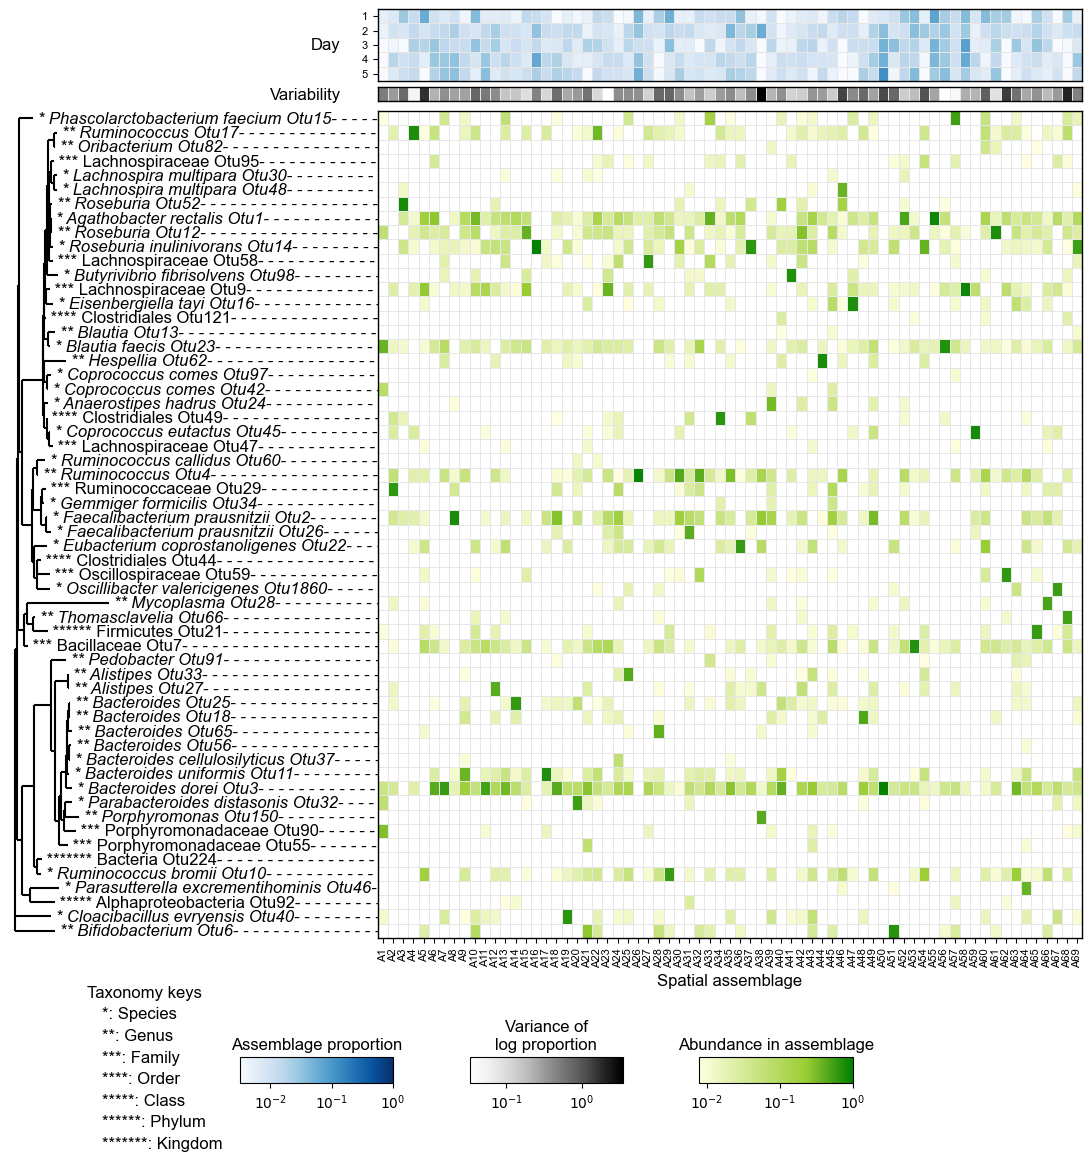

In [115]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)


ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap=var_cmap, cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    norm=var_norm)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = thetadf.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

# norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap=var_cmap, norm=var_norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([0,-1])
ax_var_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results.png", bbox_inches="tight")

#### cluster columns instead?; how to order assemblages in best way?

In [62]:
logvar = np.log10(beta.loc["Variance of log",:]).values

In [63]:
print(np.amin(logvar))
print(np.median(logvar))
print(np.amax(logvar))

-1.4900166823370267
-0.49771576405978557
0.5459905910914343


In [64]:
 thetaflat = np.reshape(thetadf.values, (-1,))

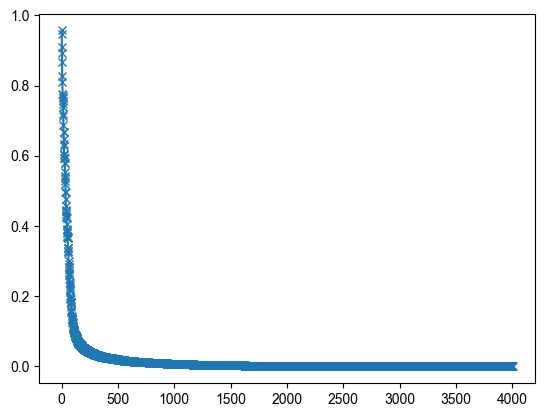

In [65]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat), '-x')

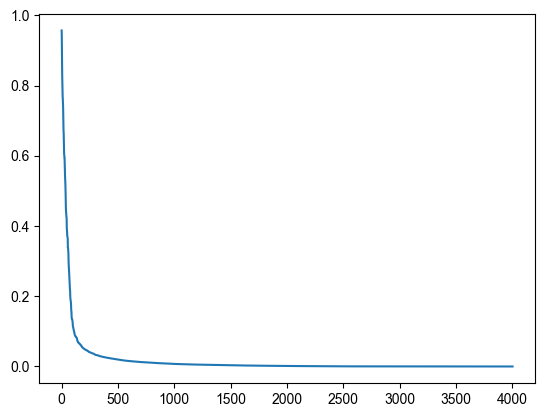

In [66]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))

(0.0, 0.1)

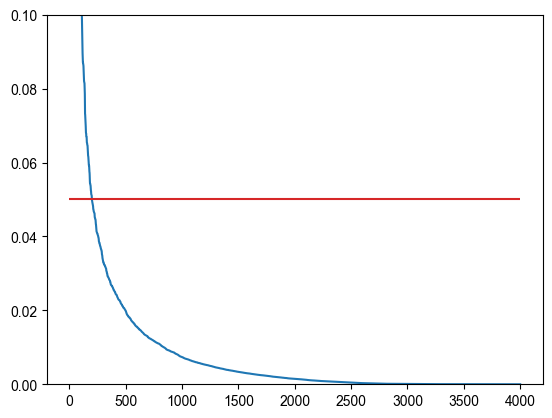

In [67]:
fig, ax = plt.subplots()
ax.plot(-np.sort(-thetaflat))
ax.hlines(0.05, 0, len(thetaflat), color='tab:red')
ax.set_ylim(0,0.1)

In [68]:
# fig, ax = plt.subplots()
# ax.plot(-np.sort(-thetaflat))
# ax.hlines(0.01, 0, len(thetaflat), color='tab:red')
# ax.set_ylim(0,0.1)
# ax.set_

(array([3889.,   34.,   16.,   14.,   13.,    7.,   12.,    7.,    5.,
           5.]),
 array([1.71466866e-07, 9.56779346e-02, 1.91355705e-01, 2.87033468e-01,
        3.82711232e-01, 4.78388995e-01, 5.74066758e-01, 6.69744492e-01,
        7.65422285e-01, 8.61100018e-01, 9.56777811e-01]),
 <BarContainer object of 10 artists>)

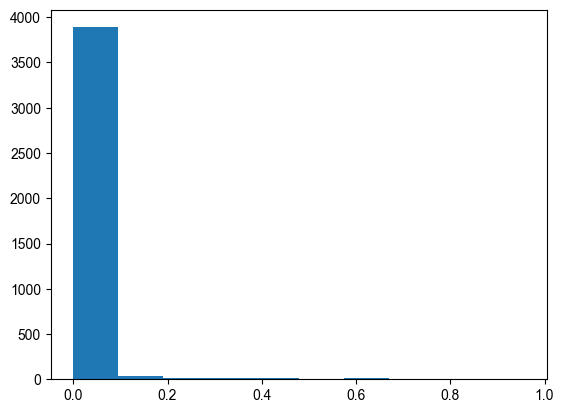

In [69]:
plt.hist(thetaflat)

In [70]:
np.percentile(thetaflat, q=95)

0.04991947375237937

In [71]:
np.percentile(thetaflat, q=50)

0.0014885813579894602

In [72]:
np.percentile(thetaflat, q=5)

6.7607274104375396e-06

# can use 0.05 for intepretation, but want to report all in heatmap

# try prob values and z-score criteria for filtering data

In [73]:
# thetadf

### compute usage probs

In [74]:
thetadf.head()

,,,,,,,,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A60,A61,A62,A63,A64,A65,A66,A67,A68,A69
Otu,Kingdom,Phylum,Class,Order,Family,Genus,Species,,,,,,,,,,,,,,,,,,,,,
Otu121,Bacteria,Firmicutes,Clostridia,Clostridiales,na,na,na,0.000052,0.000014,0.000242,0.000437,1.781666e-06,0.001734,0.003279,0.000093,0.000574,0.004239,...,0.011149,0.000042,0.000004,7.585302e-05,0.002550,0.002987,0.001211,0.000604,0.021730,0.003368
Otu14,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,Roseburia inulinivorans,0.005940,0.000244,0.041221,0.010959,5.553787e-06,0.012431,0.016941,0.016841,0.011932,0.010213,...,0.003474,0.002708,0.012941,1.539850e-02,0.013372,0.011733,0.034129,0.002216,0.008005,0.543192
Otu150,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Porphyromonas,na,0.000012,0.000029,0.000016,0.000053,1.714669e-07,0.000009,0.000002,0.000103,0.000013,0.000035,...,0.000024,0.000037,0.000036,3.372271e-07,0.000025,0.001509,0.000070,0.000007,0.001506,0.000035
Otu37,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,0.000149,0.000675,0.000004,0.000026,5.252889e-07,0.001403,0.003581,0.001785,0.009265,0.000269,...,0.000852,0.000032,0.004395,1.780347e-03,0.000019,0.000015,0.000966,0.000068,0.000111,0.000026
Otu6,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,na,0.002488,0.002598,0.000010,0.003122,2.498775e-02,0.001897,0.001975,0.000546,0.000764,0.094230,...,0.000474,0.012422,0.004437,9.384204e-04,0.001704,0.006746,0.026253,0.003690,0.000035,0.000870


In [75]:
avebeta

Assemblage,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,...,A63,A64,A65,A66,A67,A68,A69,A7,A8,A9
Time,,,,,,,,,,,,,,,,,,,,,
1,0.005086,0.038501,0.005905,0.006020,0.006212,0.004502,0.014791,0.012369,0.008850,0.002939,...,0.003945,0.003480,0.021644,0.010315,0.002712,0.024854,0.004959,0.007007,0.010345,0.004143
2,0.004595,0.008073,0.014956,0.023427,0.010794,0.010251,0.008108,0.033123,0.011994,0.011174,...,0.010312,0.011711,0.018802,0.010303,0.006973,0.010757,0.012357,0.014197,0.021857,0.010505
3,0.002197,0.031837,0.013180,0.023536,0.008093,0.011498,0.008670,0.014300,0.006894,0.007393,...,0.028139,0.008005,0.032251,0.015696,0.002817,0.003478,0.007386,0.015733,0.012068,0.012410
4,0.002435,0.008395,0.029107,0.010989,0.017411,0.010879,0.006916,0.065324,0.015942,0.019776,...,0.006654,0.009606,0.011880,0.006081,0.007700,0.000903,0.028452,0.029017,0.032866,0.014532
5,0.000886,0.005407,0.037243,0.006357,0.010025,0.008308,0.011263,0.021726,0.012271,0.019815,...,0.005702,0.011010,0.007100,0.005401,0.009518,0.001261,0.014518,0.030867,0.034671,0.013951


In [76]:
t = thetadf.values
b = avebeta.loc[:,thetadf.columns].values
print(t.shape)
print(b.shape)

(58, 69)
(5, 69)


In [77]:
btave = np.mean(b,axis=0)
print(btave.shape)

(69,)


In [78]:
usage = (t*btave)/np.sum(t*btave, axis=1, keepdims=True)

In [79]:
usage.shape

(58, 69)

In [80]:
print(usage.sum(axis=1))
print(len(usage.sum(axis=1)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
58


In [81]:
ncomm = t.shape[1]
print(ncomm)

69


In [82]:
randprob = 1.0/ncomm
print(randprob)

0.014492753623188406


In [83]:
print(usage.shape[0]*usage.shape[1])
print((usage>randprob).sum())

4002
670


In [84]:
usage.shape

(58, 69)

In [85]:
thetadf_psparse = thetadf.copy()
thetadf_psparse[usage<randprob] = 0

In [86]:
# thetadf

original tree size: 3923
pruned tree size: 58


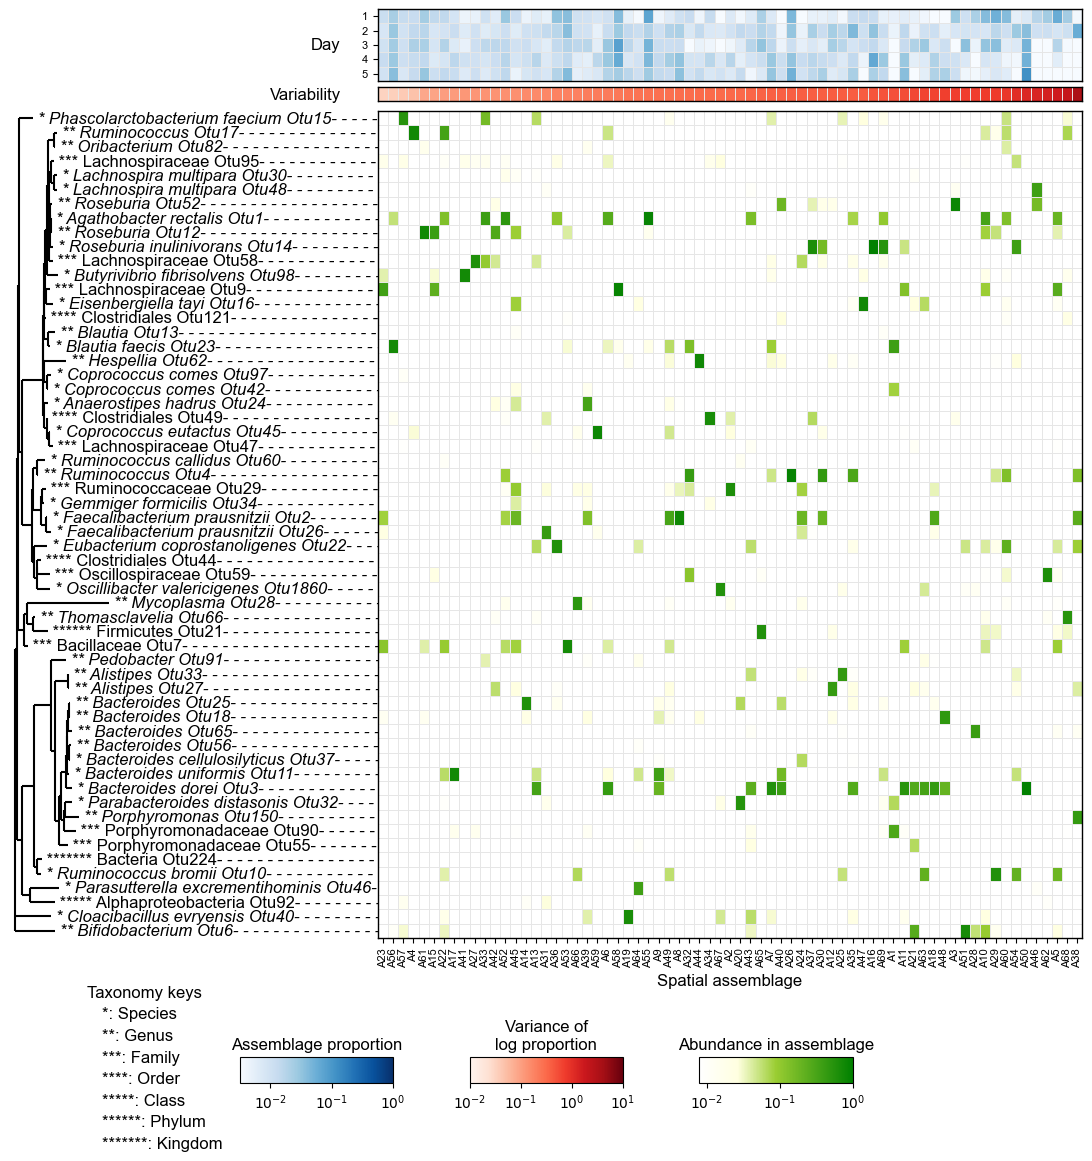

In [87]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = thetadf_psparse.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_prob_sparse.png", bbox_inches="tight")

In [88]:
# thetadf

In [89]:
# thetadf

In [90]:
print((thetadf.values>0.01).sum())
print((thetadf_psparse.values>0).sum())
print((thetadf.values>0.01).sum() - (thetadf_psparse.values>0).sum())

838
670
168


In [91]:
print((thetadf.values>0.05).sum())
print((thetadf_psparse.values>0).sum())
print((thetadf.values>0.05).sum() - (thetadf_psparse.values>0).sum())

200
670
-470


## try with z-scores

In [92]:
t.shape

(58, 69)

In [93]:
z = (t - np.mean(t,axis=1,keepdims=True))/(np.std(t, axis=1, keepdims=True))

In [94]:
z.shape

(58, 69)

In [95]:
print((z>2).sum())
print((z>3).sum())

120
77


In [96]:
# z

In [97]:
theta_zsparse2 = thetadf.copy()
theta_zsparse3 = thetadf.copy()

theta_zsparse2[z<2] = 0
theta_zsparse3[z<3] = 0


In [98]:
theta_zsparse0 = thetadf.copy()
theta_zsparse0[z<0] = 0

In [99]:
print((z>0).sum())

648


original tree size: 3923
pruned tree size: 58


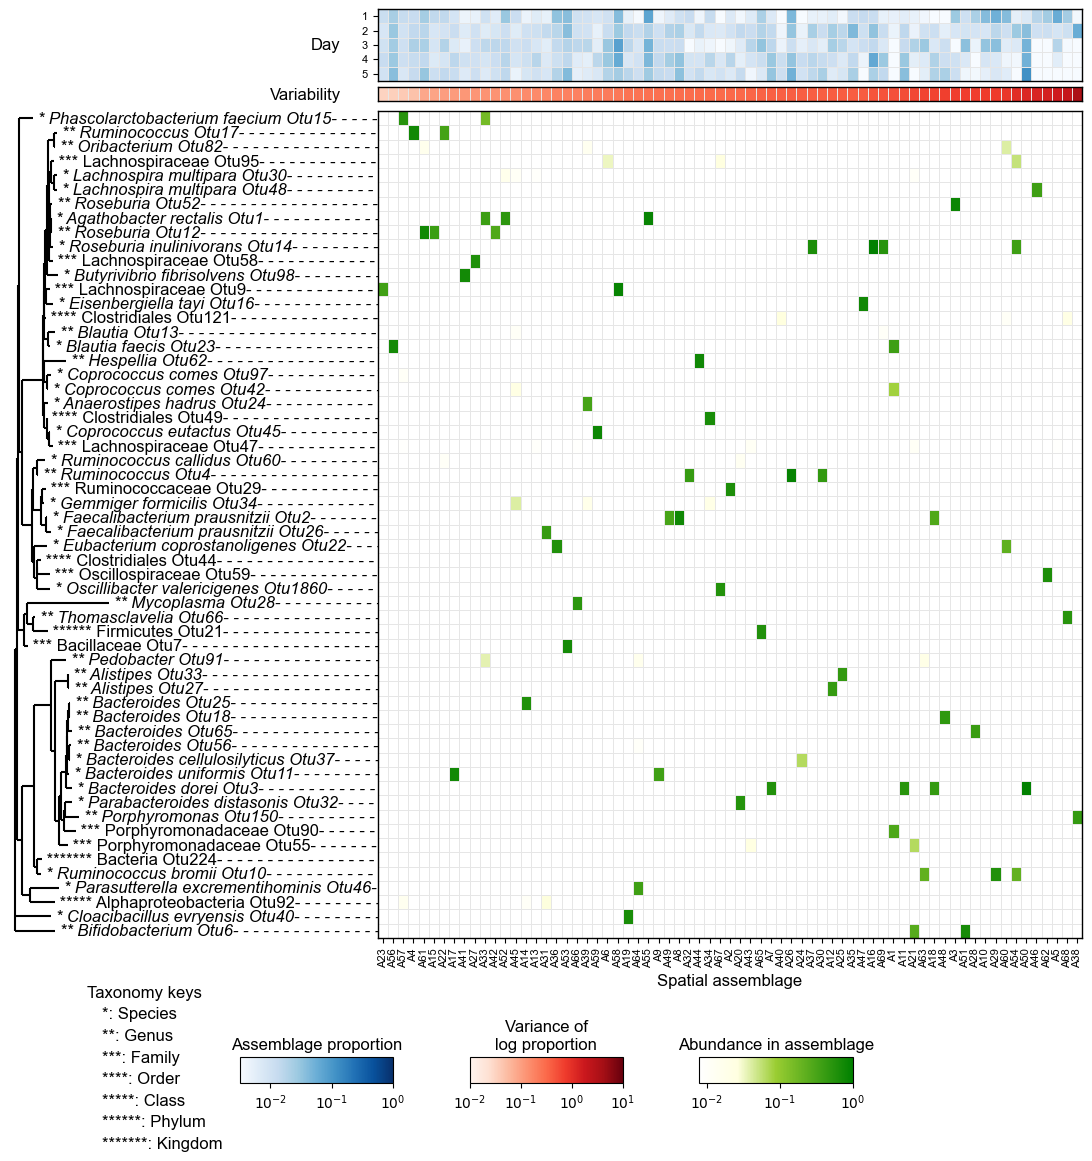

In [100]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = theta_zsparse2.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_cutoff_zscore2.png", bbox_inches="tight")

original tree size: 3923
pruned tree size: 58


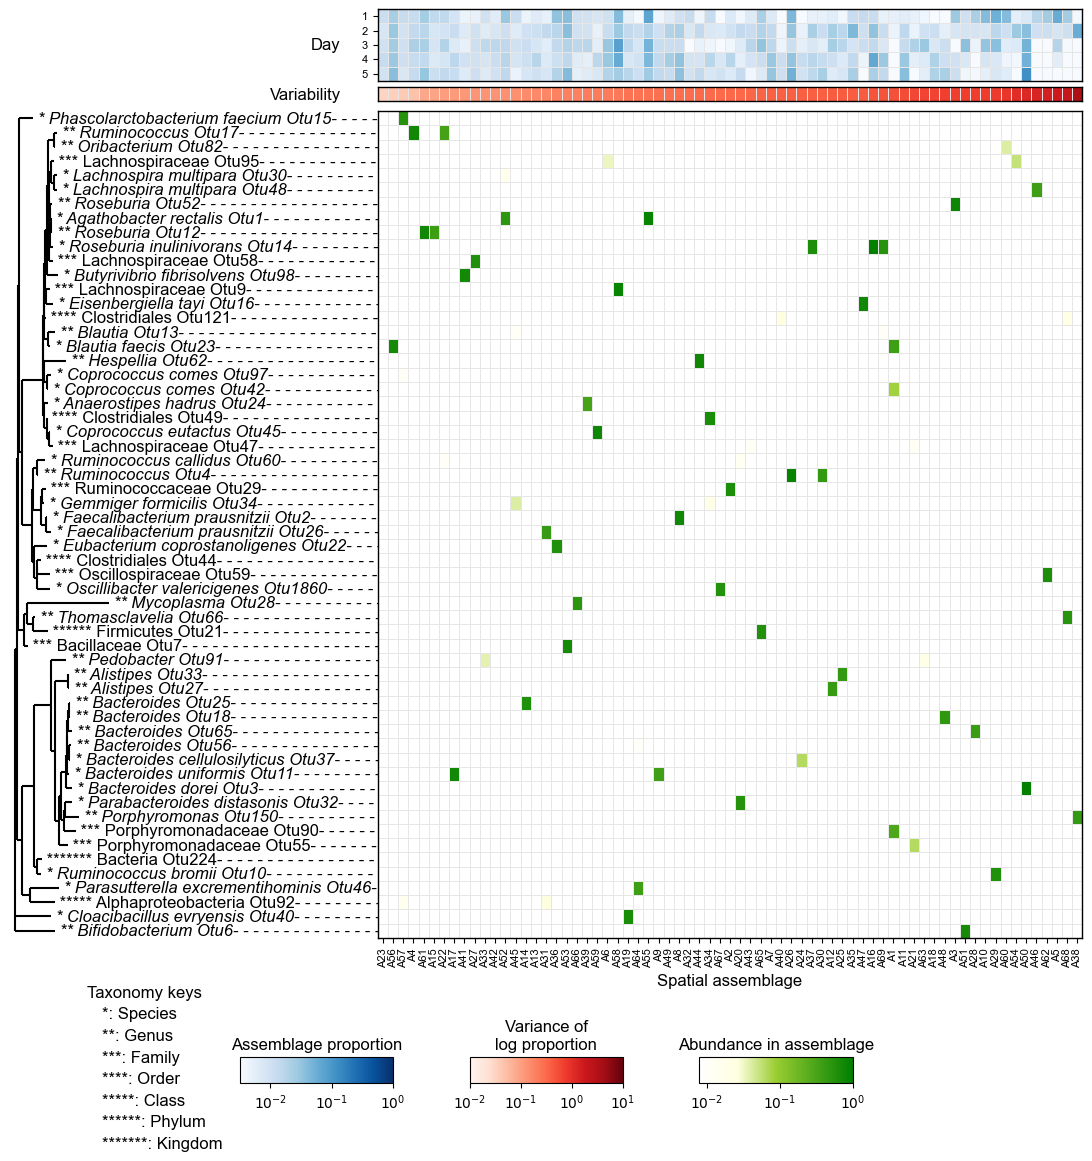

In [101]:
scale=2

labelpad = 15

lgd_ratio = 0.05
lgd_gap = 0.06

# set aspect ratios
# add buffers so scales always same?
hratios = [ntime/notu_max, 1/notu_max, notus/notu_max, lgd_gap, lgd_ratio]
hratios.append(1.0 - (nsubj*ntime/notu_max) - (notus/notu_max) - lgd_ratio - lgd_gap) # buffer?
wratios = [tree_ratio, gap_ratio, ncomm/ncomm_max, 1.0-gap_ratio-tree_ratio-(ncomm/ncomm_max)]

# create figure
fig = plt.figure(figsize=(8.5*scale,11.5*scale))
gs = fig.add_gridspec(nrows=6,ncols=4,
                    height_ratios=hratios,
                      width_ratios=wratios,
                    wspace=0.1,
                     hspace=0.02)

# create subplots, get axes
ax_beta = fig.add_subplot(gs[0,2])
ax_var = fig.add_subplot(gs[1,2])
ax_tree = fig.add_subplot(gs[2,0])

# create subgridspecs to squish heatmaps and align tree to center
squish_ratio = 0.005
squish_hspace = 0
gs_theta = gs[2,2].subgridspec(3,1, height_ratios=[squish_ratio,1,squish_ratio], hspace=squish_hspace)
ax_theta = fig.add_subplot(gs_theta[1,0])


# for legend...
gs_lgd = gs[-2,:-1].subgridspec(3,5, wspace=0.5)
ax_taxa_lgd = fig.add_subplot(gs_lgd[:,0])
ax_beta_lgd = fig.add_subplot(gs_lgd[0,1])
ax_var_lgd = fig.add_subplot(gs_lgd[0,2])
ax_theta_lgd = fig.add_subplot(gs_lgd[0,3])

# PLOT =====================================================
# plot assemlage proportions
# beta_order = get_abundance_order(betadf)
beta_order = beta.T.sort_values(by="Variance of log").index

ax_beta = plot_subject_proportions_timeseries(ax_beta, betadf, subj='H11', order=beta_order, vmin=-2.5)
ax_beta.set_xticks([])
ax_beta.set_yticklabels(ax_beta.get_yticklabels(), rotation=0, fontsize=subfontsize)
ax_beta.set_ylabel("Day", rotation=0, labelpad=labelpad, ha='right', fontsize=fontsize, va='center')
ax_beta.set_xlabel("")
ax_beta = add_border(ax_beta)

# plot variability
ax_var = sns.heatmap(np.log10(beta.loc[['Variance of log'], beta_order]), ax=ax_var, cmap='Reds', cbar=False,
                    linecolor ='#e6e6e6', linewidth=0.5, xticklabels=False, yticklabels=False,
                    vmin=-2, vmax=1)
ax_var.set_ylabel("Variability", fontsize=fontsize, rotation = 0, labelpad=labelpad, ha='right', va='center')
ax_var.set_xlabel("")
ax_var = add_border(ax_var)

# get data subsets
taxa = taxonomy.reset_index()
taxa.rename(columns={'OTU':'Otu'}, inplace=True)
taxa_subset = taxa.set_index("Otu") #taxa.iloc[otu_sub,:].set_index("Otu")
tree = get_pruned_tree(treepath, treefile, taxa_subset, temppath=Path("./_tmp_sub"))

# plot tree
ax_tree, otu_order = vis.plot_phylo_tree(ax_tree, tree, taxonomy, fontsize=fontsize, text_len=60)

# plot assemblages
thetadf2 = theta_zsparse3.copy()

# thetadf2[thetadf2<otu_threshold] = 0
ax_theta=plot_assemblages(ax_theta, thetadf2, otu_order, beta_order, cmap=theta_cmap, norm=theta_norm) #, cmap=extended_cmap, vmin=-3) #'Greens')
ax_theta.set_ylabel("")
ax_theta.set_xticklabels(ax_theta.get_xticklabels(), rotation=90, fontsize=subfontsize)
ax_theta = add_border(ax_theta)
ax_theta.set_xlabel("Spatial assemblage", fontsize=fontsize)


# plot legend
norm = mpl.colors.Normalize(vmin=-2.5, vmax=0)
ax_beta_lgd=mpl.colorbar.ColorbarBase(ax_beta_lgd, cmap="Blues", norm=norm, orientation='horizontal')
ax_beta_lgd.ax.set_xticks([0, -1,-2])
ax_beta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_beta_lgd.ax.set_title("Assemblage proportion", fontsize=fontsize)

norm = mpl.colors.Normalize(vmin=-2, vmax=1)
ax_var_lgd=mpl.colorbar.ColorbarBase(ax_var_lgd, cmap="Reds", norm=norm, orientation='horizontal')
ax_var_lgd.ax.set_xticks([1, 0,-1,-2])
ax_var_lgd.ax.set_xticklabels([r'$10^{1}$',r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_var_lgd.ax.set_title("Variance of\nlog proportion")

norm = theta_norm
ax_theta_lgd=mpl.colorbar.ColorbarBase(ax_theta_lgd, cmap=theta_cmap, norm=norm, orientation='horizontal')
ax_theta_lgd.ax.set_xticks([0,-1,-2])
ax_theta_lgd.ax.set_xticklabels([r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$'])
ax_theta_lgd.ax.set_title("Abundance in assemblage")



lgd_xpos=0.5
lgd_ypos=1.2+0.5
indent_xpos=lgd_xpos+0.1
dy=0.25
lgd_fontsize=12

levels = ['Species','Genus', 'Family', 'Order', 'Class', 'Phylum', 'Kingdom']      
level_dict = {'Species': '*', 'Genus': '**', 'Family': '***', 'Order': '****', 'Class': '*****', 'Phylum': '******', 'Kingdom': '*******'}
    
ax_taxa_lgd.text(lgd_xpos,lgd_ypos,"Taxonomy keys", fontsize=lgd_fontsize)
for i,level in enumerate(levels):
    ax_taxa_lgd.text(indent_xpos, lgd_ypos - (i+1)*dy, f"{level_dict[level]}: {level}", fontsize=lgd_fontsize)
ax_taxa_lgd=vis.remove_border(ax_taxa_lgd)

# align labels
fig.align_ylabels([ax_beta, ax_var])
plt.savefig(outpath / "human_full_results_cutoff_zscore3.png", bbox_inches="tight")

# output csv files

In [102]:
usage.shape

(58, 69)

In [103]:
usagedf = pd.DataFrame(usage, index=thetadf.index, columns=thetadf.columns)
zscoredf = pd.DataFrame(z, index=thetadf.index, columns=thetadf.columns)

In [104]:
thetadf_psparse.to_csv(outpath / "assemblages_prob_cutoff.csv")
theta_zsparse2.to_csv(outpath / "assemblages_cutoff_zscore2.csv")
theta_zsparse3.to_csv(outpath / "assemblages_cutoff_zscore3.csv")

usagedf.to_csv(outpath / "otu_assemblage_probabilities.csv")
zscoredf.to_csv(outpath / "zscores.csv")

In [105]:
outpath

WindowsPath('figs_human_results')